<a href="https://colab.research.google.com/github/natimellino/mineria-de-datos/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 1
## Mellino, Natalia

In [1]:
## Imports

library(MASS)
# install.packages("ggplot2")
library(ggplot2)
# install.packages("caret", dependencies = TRUE)
library(caret)
library(rpart)
library(class)

Loading required package: lattice

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


## Ejercicio 1

### Apartado a)

In [2]:
## Apartado a)

generar_diagonal <- function(n, d, C){
  # Centros
  center0 = rep(-1, times=d)
  center1 = rep(1, times=d)

  ## Matriz diagonal de desviación estándar
  desviacion = C * sqrt(d)
  matriz = diag(rep(desviacion, times=d))

  ## Generamos los puntos aleatorios y construimos el dataframe
  points0 = mvrnorm(floor(n / 2), center0, matriz)
  points1 = mvrnorm(ceiling(n / 2), center1, matriz)

  clase0 = cbind(points0, rep(0, times=floor(n / 2)))
  clase1 = cbind(points1, rep(1, times=ceiling(n / 2)))

  return(as.data.frame(rbind(clase0, clase1)))

}

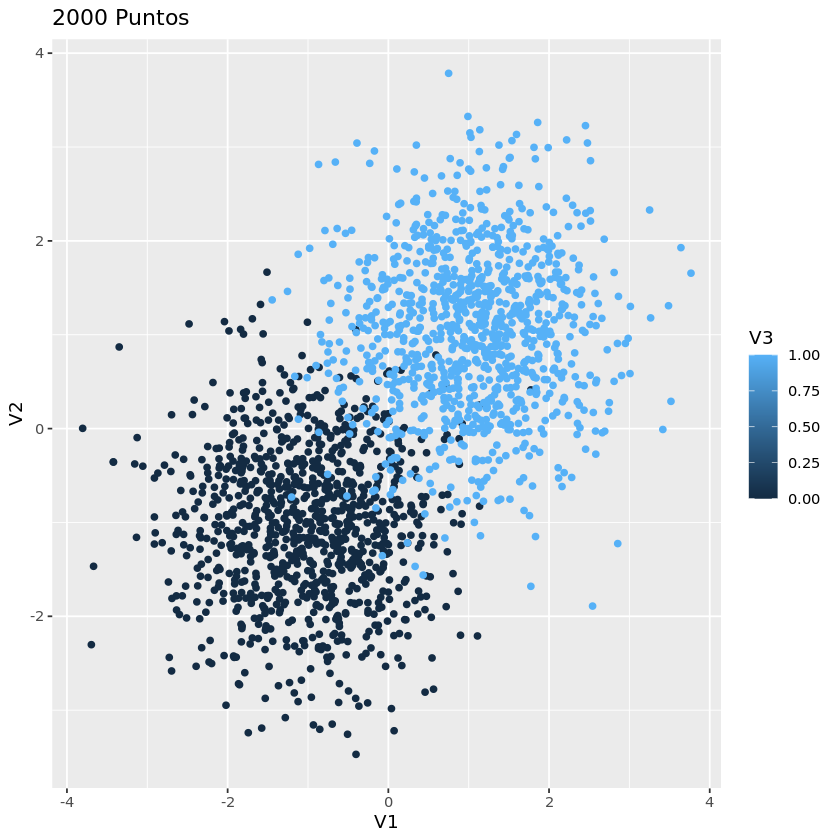

In [3]:
data = generar_diagonal(2000, 2, 0.5)
ggplot(data, 
       aes(x=V1, 
           y=V2,
           color = V3)) +
  geom_point() + 
  labs(title = "2000 Puntos")


### Apartado b)

In [4]:
curva1 <- function(alfa){
  return(alfa / (4 * pi))
}

curva2 <- function(alfa){
  return((alfa + pi) / (4 * pi))
}


In [5]:
generar_espirales <- function(n){
  cantidad_clase0 = 0
  cantidad_clase1 = 0

  len0 = floor(n / 2)
  len1 = n - len0

  clase = vector()
  x = vector()
  y = vector()

  while(cantidad_clase0 < len0 || cantidad_clase1 < len1){
    alfa = 2 * pi * runif(1, min=0, max=1)
    r = sqrt(runif(1, min=0, max=1))

    flag = FALSE
    values = c(
      alfa + 2 * pi * (-1), 
      alfa + 2 * pi * (0), 
      alfa + 2 * pi * (1), 
      alfa + 2 * pi * (2), 
      alfa + 2 * pi * (3), 
      alfa + 2 * pi * (4),
      alfa + 2 * pi * (5)
    )

    for(i in values){
      if(curva1(i) < r && r < curva2(i)){
          if(cantidad_clase1 < len1){
            cantidad_clase1 = cantidad_clase1 + 1
            x = append(x, r * cos(alfa))
            y = append(y, r * sin(alfa))

            clase = append(clase, 1)
          }
          flag = TRUE
      }
    }

    if (cantidad_clase0 < len0 && !flag) {
      cantidad_clase0 = cantidad_clase0 + 1
      x = append(x, r * cos(alfa))
      y = append(y, r * sin(alfa))

      clase = append(clase, 0)
    }

  }

  return(as.data.frame(cbind(x, cbind(y, clase))))

}

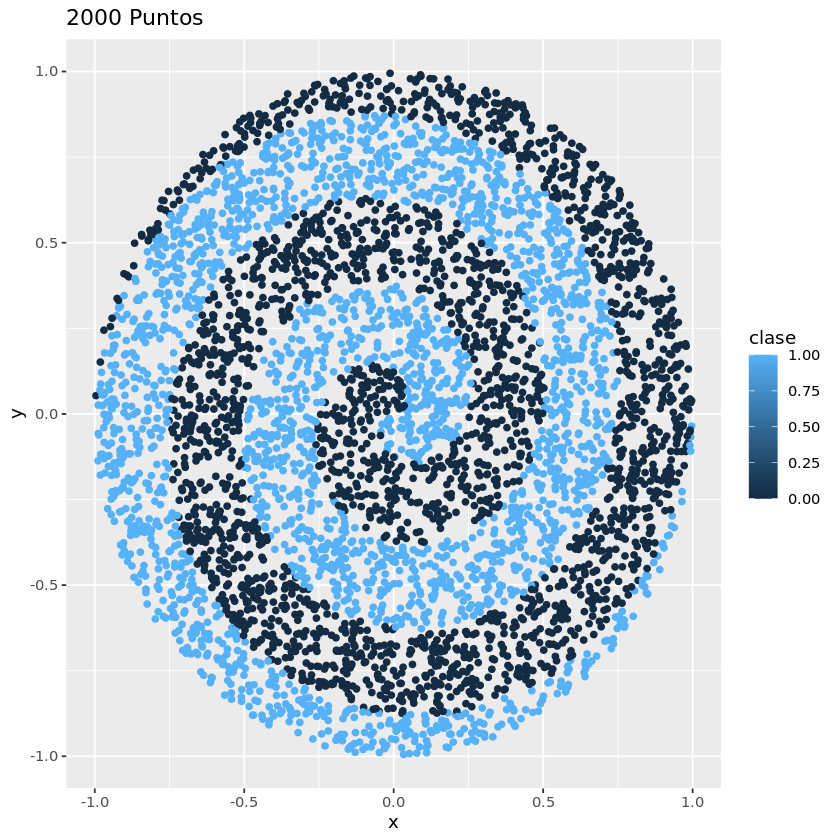

In [6]:
data = generar_espirales(5000)
ggplot(data, 
       aes(x=x, 
           y=y,
           color = clase)) +
  geom_point() + 
  labs(title = "2000 Puntos")

## Ejercicio 3

### Árboles de Desición

#### Sin folds

In [7]:
arboles_sin_fold <- function(){

    ## Generamos conjuntos de entrenamiento y de test

    diagonal_train = generar_diagonal(200, 2, 0.5)
    diagonal_test = generar_diagonal(2000, 2, 0.5)

    espiral_train = generar_espirales(200)
    espiral_test = generar_espirales(2000)

    ## Entrenamos los modelos

    fitted_model_diagonal <- rpart(V3~., data=diagonal_train, method='class')
    fitted_model_espiral <- rpart(clase~., data=espiral_train, method='class')

    ## Realizamos las predicciones

    predict_diagonal <- predict(fitted_model_diagonal, diagonal_test[-3], type='class')
    predict_espiral <- predict(fitted_model_espiral, espiral_test[,-3], type='class')

    ## Error diagonal: usamos 1 - accuracy

    matrix_gain_diagonal <- table(predict_diagonal, diagonal_test[,3])
    acuraccy_gain_diagonal <- sum(diag(matrix_gain_diagonal)) / sum(matrix_gain_diagonal)

    ## Error espirales

    matrix_gain_espiral <- table(predict_espiral, espiral_test[,3])
    acuraccy_gain_espiral <- sum(diag(matrix_gain_espiral)) / sum(matrix_gain_espiral)
    1 - acuraccy_gain_espiral

    return(c(1 - acuraccy_gain_diagonal, 1 - acuraccy_gain_espiral))
}

#### Con folds

In [11]:
arboles_con_fold <- function(){
    
    ## Creamos los folds

    diagonal_train = generar_diagonal(200, 2, 0.5)
    espiral_train = generar_espirales(200)

    k = 5
    index_data_diagonal = createFolds(t(diagonal_train[, 'V3']), k=k)
    index_data_espiral = createFolds(t(espiral_train[, 'clase']), k=k)

    errores_diagonal = c()
    errores_espiral = c()

    for(i in 1:k){
        ## Conjuntos de entrenamiento y test

        diagonal_train_k = diagonal_train[setdiff(seq(1 : dim(diagonal_train)[1]), index_data_diagonal[[i]]) , ]
        diagonal_test_k = diagonal_train[index_data_diagonal[[i]] , ]

        espiral_train_k = espiral_train[setdiff(seq(1 : dim(espiral_train)[1]), index_data_espiral[[i]]) , ]
        espiral_test_k = espiral_train[index_data_espiral[[i]] , ]

        # Entrenamos

        fitted_model_diagonal_k <- rpart(V3~., data=diagonal_train_k, method='class')
        fitted_model_espiral_k <- rpart(clase~., data=espiral_train_k, method='class')

        ## Realizamos las predicciones

        predict_diagonal_k <- predict(fitted_model_diagonal_k, diagonal_test_k[-3], type='class')
        predict_espiral_k <- predict(fitted_model_espiral_k, espiral_test_k[,-3], type='class')

        ## Error diagonal: usamos 1 - accuracy

        matrix_gain_diagonal_k <- table(predict_diagonal_k, diagonal_test_k[,3])
        acuraccy_gain_diagonal_k <- sum(diag(matrix_gain_diagonal_k)) / sum(matrix_gain_diagonal_k)
        errores_diagonal[i] = 1 - acuraccy_gain_diagonal_k

        ## Error espirales: usamos 1 - accuracy

        matrix_gain_espiral_k <- table(predict_espiral_k, espiral_test_k[,3])
        acuraccy_gain_espiral_k <- sum(diag(matrix_gain_espiral_k)) / sum(matrix_gain_espiral_k)
        errores_espiral[i] = 1 - acuraccy_gain_espiral_k
    }

    error_diagonal = sum(errores_diagonal) / k
    error_espiral = sum(errores_espiral) / k

    return(c(error_diagonal, error_espiral))

}

In [23]:
arboles_con = arboles_con_fold()
arboles_sin = arboles_sin_fold()
df <- data.frame(
    'Dataset'=c('Diagonal', 'Espirales'), 
    'Error_sin_fold'=c(arboles_sin[1], arboles_sin[2]),
    'Error_con_5fold'=c(arboles_con[1], arboles_con[2])
    )
df

Dataset,Error_sin_fold,Error_con_5fold
<chr>,<dbl>,<dbl>
Diagonal,0.087,0.095
Espirales,0.291,0.350


### K-Vecinos

#### Sin Fold

In [13]:
knn_sin_fold <- function(){

    ## Generamos conjuntos de entrenamiento y de test

    diagonal_train = generar_diagonal(200, 2, 0.5)
    diagonal_test = generar_diagonal(2000, 2, 0.5)
    diagonal_train_category = diagonal_train[, 3]
    diagonal_test_category = diagonal_test[, 3]

    espiral_train = generar_espirales(200)
    espiral_test = generar_espirales(2000)
    espiral_train_category = espiral_train[, 3]
    espiral_test_category  = espiral_test[, 3]

    ## Entrenamos los modelos

    knn_fitted_model_diagonal <- knn(diagonal_train[, -3], diagonal_test[-3], cl=diagonal_train_category, k=3)
    knn_fitted_model_espiral <- knn(espiral_train[, -3], espiral_test[, -3], cl=espiral_train_category, k=3)

    table_diagonal = table(knn_fitted_model_diagonal, diagonal_test_category)
    knn_error_diagonal = 1 - (sum(diag(table_diagonal)) / sum(table_diagonal))

    table_espiral = table(knn_fitted_model_espiral, espiral_test_category)
    knn_error_espiral = 1 - (sum(diag(table_espiral)) / sum(table_espiral))

    return(c(knn_error_diagonal, knn_error_espiral))

}

#### Con Fold

In [28]:
knn_con_fold <- function(){

    ## Creamos los folds

    diagonal_train = generar_diagonal(200, 2, 0.5)
    espiral_train = generar_espirales(200)

    k = 5
    index_data_diagonal = createFolds(t(diagonal_train[, 'V3']), k=k)
    index_data_espiral = createFolds(t(espiral_train[, 'clase']), k=k)

    errores_diagonal = c()
    errores_espiral = c()

    for(i in 1:k){
        ## Conjuntos de entrenamiento y test

        diagonal_train_k = diagonal_train[setdiff(seq(1 : dim(diagonal_train)[1]), index_data_diagonal[[i]]) , ]
        diagonal_test_k = diagonal_train[index_data_diagonal[[i]] , ]
        diagonal_train_category = diagonal_train_k[, 3]
        diagonal_test_category = diagonal_test_k[, 3]

        espiral_train_k = espiral_train[setdiff(seq(1 : dim(espiral_train)[1]), index_data_espiral[[i]]) , ]
        espiral_test_k = espiral_train[index_data_espiral[[i]] , ]
        espiral_train_category = espiral_train_k[, 3]
        espiral_test_category  = espiral_test_k[, 3]

        # Entrenamos

        knn_fitted_model_diagonal <- knn(diagonal_train_k[, -3], diagonal_test_k[-3], cl=diagonal_train_category, k=3)
        knn_fitted_model_espiral <- knn(espiral_train_k[, -3], espiral_test_k[, -3], cl=espiral_train_category, k=3)

        # Error

        table_diagonal = table(knn_fitted_model_diagonal, diagonal_test_category)
        knn_error_diagonal = 1 - (sum(diag(table_diagonal)) / sum(table_diagonal))
        errores_diagonal[i] = knn_error_diagonal

        table_espiral = table(knn_fitted_model_espiral, espiral_test_category)
        knn_error_espiral = 1 - (sum(diag(table_espiral)) / sum(table_espiral))
        errores_espiral[i] = knn_error_espiral
    }

    error_diagonal = sum(errores_diagonal) / k
    error_espiral = sum(errores_espiral) / k

    return(c(error_diagonal, error_espiral))
}

Resumimos en la siguiente tabla los resultados obtenidos:

In [34]:
knn_sin = knn_sin_fold()
knn_con = knn_con_fold()

df <- data.frame(
    'Dataset'=c('Diagonal', 'Espirales'), 
    'Error_sin_fold'=c(knn_sin[1], knn_sin[2]),
    'Error_con_5fold'=c(knn_con[1], knn_con[2])
    )
df

Dataset,Error_sin_fold,Error_con_5fold
<chr>,<dbl>,<dbl>
Diagonal,0.0615,0.085
Espirales,0.1855,0.220


### Conclusiones

Tanto en árboles como en knn podemos observar que el error fue mayor al utilizar folds. Sin embargo, en el problema del diagonal la diferencia no es muy notable. Luego de varias corridas se pueden observar casos donde pasa lo contrario: el error sin folds es mayor que usando folds.

El problema de las espirales es notablemente más complicado, tanto para árboles como para knn, a comparación del diagonal donde podemos observar muchísimo menos error, por lo que concluimos que nuestro clasificador es bueno para el problema de las diagonales pero tal vez para el de las espirales no es muy adecuado.